In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from src.vae.model.beta_vae import BetaVAE  # adjust import path if needed
from src.vae.model.config import VAEConfig


cfg = VAEConfig()
device = cfg.device
height, width = 64, 64
vae = BetaVAE(cfg, in_height=height, in_width=width).to(device)

ckpt_path = 'checkpoints/celebA/beta_vae2/checkpoint.pth'
model_path = 'models/celebA/beta_vae2/beta_vae2.pth'

ckpt = torch.load(model_path, map_location=device)
# pull out the same key you used when saving:
state_dict = ckpt['model_state']
vae.load_state_dict(state_dict)


IMG_DIR = 'data/celeba/img_align_celeba'
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize((height, width)),
    transforms.ToTensor(),
])
full_ds = ImageFolder(root=IMG_DIR, transform=transform)
val_size   = int(0.2 * len(full_ds))
train_size = len(full_ds) - val_size
torch.manual_seed(42)
_, val_ds = random_split(full_ds, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False,
                        num_workers=4, pin_memory=True)


In [2]:
import torch.nn.functional as F

# feed real x → μ, logσ  then force z = 0  (the prior mean)
x, _ = next(iter(val_loader))
x = x.to(device)
mu, logvar = vae.encoder(x)
with torch.no_grad():
    recon_z     = vae.decoder(mu)            #   z = μ          (normal forward)
    recon_zero  = vae.decoder(torch.zeros_like(mu)) # z = 0
print("MSE( x , recon_z    ) =", F.mse_loss(recon_z , x).item())
print("MSE( x , recon_zero ) =", F.mse_loss(recon_zero, x).item())

# errors identical -> decoder ignore z -> posterior colapse


MSE( x , recon_z    ) = 0.01163061335682869
MSE( x , recon_zero ) = 0.45740851759910583


In [3]:
kld_element = mu.pow(2) + logvar.exp() - logvar - 1        # [B, latent]
true_kl_per_image = 0.5 * kld_element.sum(1)               # [B]
print("true KL  (mean over batch) :", true_kl_per_image.mean().item())
print("budgeted KL you train on   :", torch.clamp(true_kl_per_image -
        cfg.free_nats * cfg.latent_dim, min=0).mean().item())


# If true KL ≪ 5–10 nats / image, the encoder collapsed.
# If true KL ≫ 100, β=1 may be over-regularising → blurry.

true KL  (mean over batch) : 82.05909729003906
budgeted KL you train on   : 18.059101104736328


In [4]:
# variance of μ across an entire epoch of validation data
mus = []
with torch.no_grad():
    for xb,_ in val_loader:
        mu,_ = vae.encoder(xb.to(device))
        mus.append(mu.cpu())
mus = torch.cat(mus, 0)           # [N, 64]
print("per-dim μ variance  (mean) :", mus.var(0).mean().item())
print("largest 10 variances       :", torch.sort(mus.var(0), descending=True)[0][:10])


# Healthy run: variance ~ 0.2–0.6 on several dims.
# Collapse: variance ~ 0.00x.

per-dim μ variance  (mean) : 0.31196653842926025
largest 10 variances       : tensor([0.5580, 0.5478, 0.5468, 0.5289, 0.5077, 0.4838, 0.4833, 0.4598, 0.4531,
        0.4493])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08109412..0.97307676].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28574646..0.9422961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14884642..0.9729969].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2506688..0.6884398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1784605..0.87447673].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18178898..0.94338226].


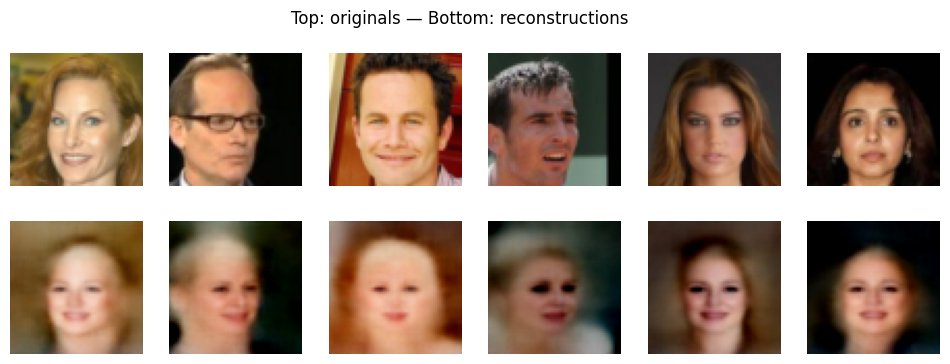

In [5]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# assume device, train_loader and vae are already defined
vae.eval()
imgs, _ = next(iter(val_loader))
imgs = imgs.to(device)
with torch.no_grad():
    recon, _, _ = vae(imgs)

# move to CPU and plot a few
imgs, recon = imgs.cpu(), recon.cpu()
n = 6
fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
for i in range(n):
    axes[0,i].imshow(imgs[i].permute(1,2,0))
    axes[0,i].axis('off')
    axes[1,i].imshow(recon[i].permute(1,2,0))
    axes[1,i].axis('off')
plt.suptitle("Top: originals — Bottom: reconstructions")
plt.show()


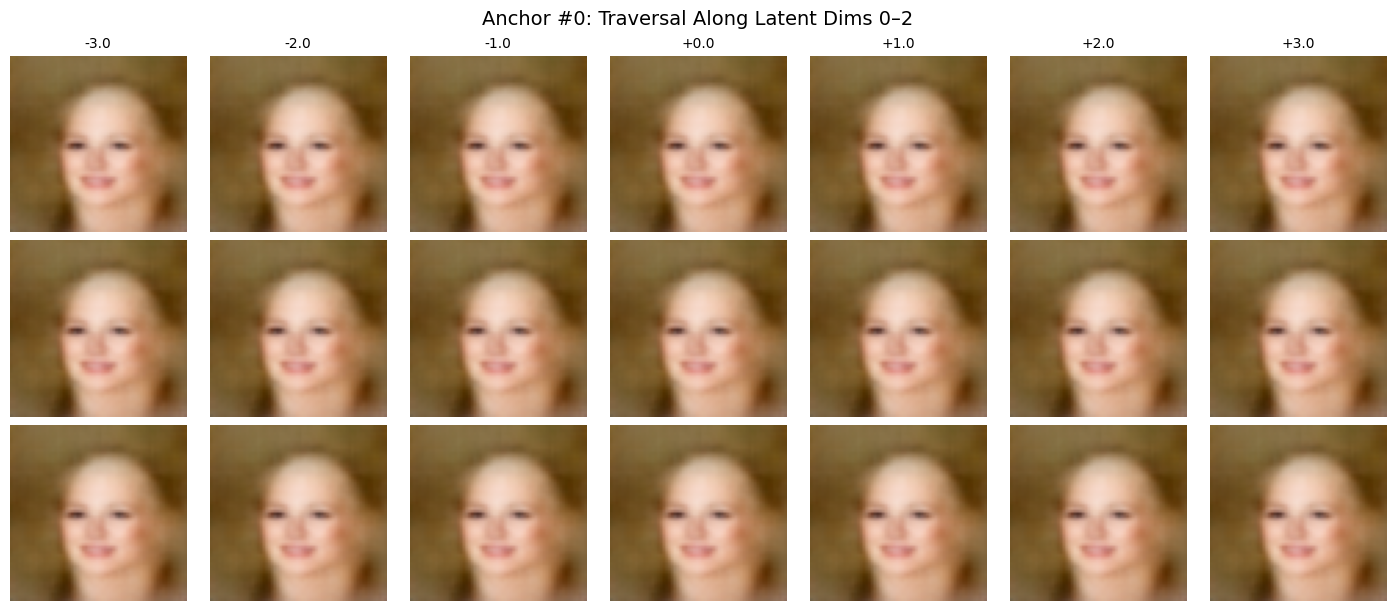

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ─── SETTINGS ────────────────────────────────────────────────────────────────
n_anchors = 1       # how many example images to pick
dims      = 3       # how many latent dims to traverse (from 0 to dims-1)
k_steps   = np.array([-3, -2, -1, 0, 1, 2, 3], dtype=np.float32)

# ─── 1) COLLECT ANCHORS ──────────────────────────────────────────────────────
anchors_imgs = []
anchors_mus  = []

with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        mu, _ = vae.encoder(imgs)                # [B, latent_dim]
        mu = mu.cpu().numpy()
        imgs_cpu = imgs.cpu()

        for i in range(imgs_cpu.size(0)):
            anchors_imgs.append(imgs_cpu[i])      # Tensor [3×64×64]
            anchors_mus.append(mu[i])             # array [latent_dim]
            if len(anchors_imgs) >= n_anchors:
                break
        if len(anchors_imgs) >= n_anchors:
            break

anchors_imgs = anchors_imgs[:n_anchors]
anchors_mus  = np.stack(anchors_mus[:n_anchors], axis=0)  # shape [n_anchors, latent_dim]

# ─── 2) COMPUTE PER-DIM SIGMA ────────────────────────────────────────────────
# use the empirical std of the collected μ’s as a step‐size scale
sigma_per_dim = anchors_mus.std(axis=0)  # [latent_dim]

# ─── 3) DO THE TRAVERSALS ───────────────────────────────────────────────────
for idx in range(n_anchors):
    z0 = anchors_mus[idx].copy()           # the “center” latent
    fig, axes = plt.subplots(dims, len(k_steps),
                             figsize=(14, 2*dims),
                             constrained_layout=True)

    for row, d in enumerate(range(dims)):
        for col, k in enumerate(k_steps):
            z_mod = z0.copy()
            z_mod[d] += k * sigma_per_dim[d]    # move along dim d

            # decode
            z_t = torch.from_numpy(z_mod.astype(np.float32))\
                        .unsqueeze(0).to(device)
            with torch.no_grad():
                recon = vae.decoder(z_t)        # [1,3,64,64]
            recon = recon.cpu().squeeze().permute(1,2,0).numpy()

            ax = axes[row, col]
            ax.imshow(np.clip(recon, 0, 1))
            ax.axis('off')

            if row == 0:
                ax.set_title(f"{k:+.1f}", fontsize=10)

        # label each row with the latent‐dim index
        axes[row, 0].set_ylabel(f"dim {d}", rotation=0,
                                labelpad=32, va='center')

    plt.suptitle(f"Anchor #{idx}: Traversal Along Latent Dims 0–{dims-1}", fontsize=14)
    plt.show()


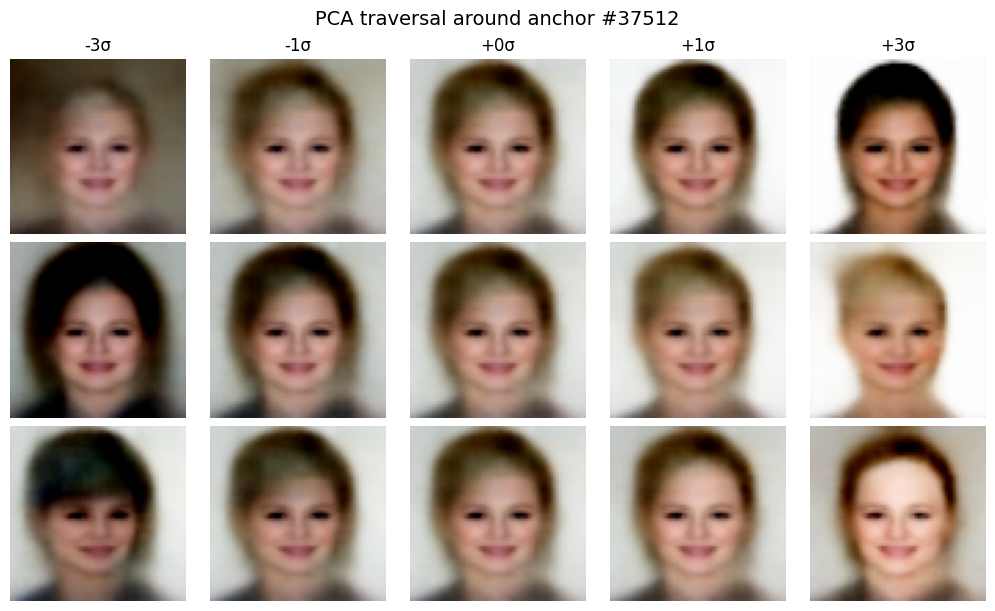

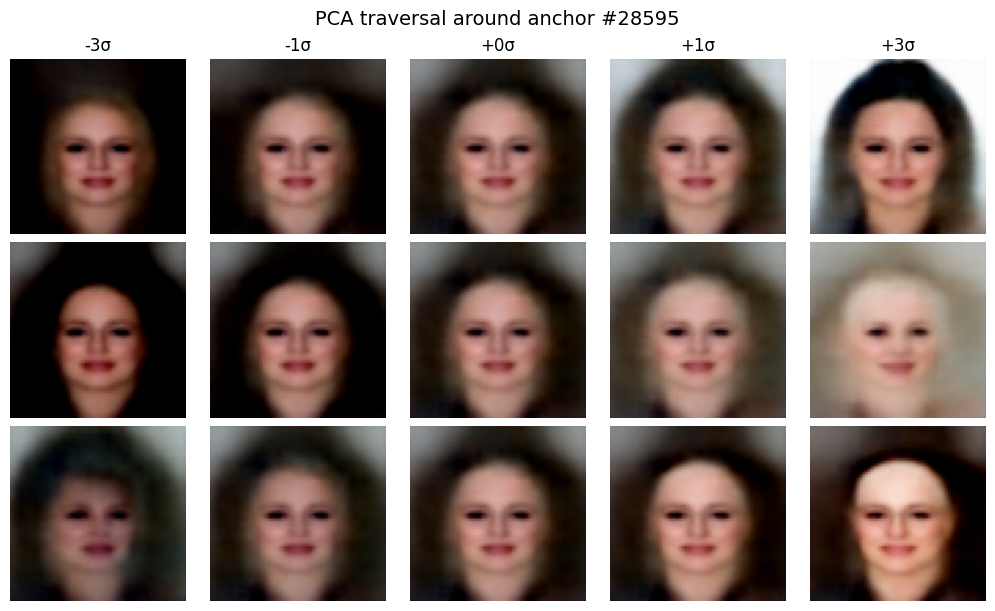

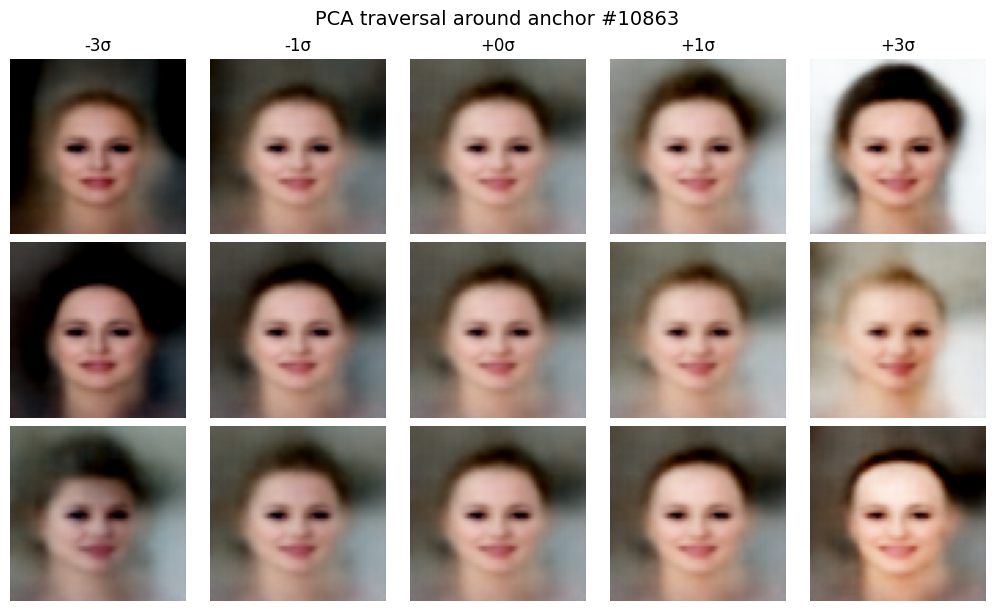

In [ ]:
import numpy as np
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ─── 1) collect all μ from the val set ───────────────────────────────────────
mus = []
with torch.no_grad():
    for x,_ in val_loader:
        x = x.to(device)
        mu, _ = vae.encoder(x)
        mus.append(mu.cpu().numpy())
mus = np.concatenate(mus, axis=0)           # shape [N, latent_dim]

# ─── 2) fit PCA ─────────────────────────────────────────────────────────────
n_pcs    = 3
pca      = PCA(n_components=n_pcs).fit(mus)
pcs      = pca.components_                 # [n_pcs, latent_dim]
pc_stds  = np.sqrt(pca.explained_variance_)# [n_pcs]

# ─── 3) define your traversal steps ────────────────────────────────────────
# here only 5 steps: -3, -1, 0, +1, +3
k_steps = np.array([-3, -1, 0, 1, 3], dtype=int)

# ─── 4) pick some anchors ──────────────────────────────────────────────────
anchors = np.random.choice(len(mus), size=3, replace=False)

# ─── 5) do the plot ────────────────────────────────────────────────────────
for idx in anchors:
    z0   = mus[idx]       # base latent
    fig, axes = plt.subplots(
        n_pcs, len(k_steps),
        figsize=(2 * len(k_steps), 2 * n_pcs),
        constrained_layout=True
    )

    # label the columns at the top row
    for col, k in enumerate(k_steps):
        axes[0, col].set_title(f"{k:+d}σ", fontsize=12)

    # traverse each PC
    for i in range(n_pcs):
        direction = pcs[i]
        std = pc_stds[i]

        for j, k in enumerate(k_steps):
            z_mod = z0 + k * std * direction
            z_t = torch.from_numpy(z_mod.astype(np.float32))\
                      .unsqueeze(0).to(device)
            with torch.no_grad():
                recon = vae.decoder(z_t)       # [1,3,64,64]

            im = recon.cpu().squeeze().permute(1,2,0).numpy()
            im = np.clip(im, 0.0, 1.0)
            
            ax = axes[i, j]
            ax.imshow(np.clip(im, 0, 1))
            ax.axis('off')

        # label each row on the left with PC index
        axes[i, 0].set_ylabel(f"PC {i+1}", rotation=0,
                              labelpad=30, va='center', fontsize=12)

    plt.suptitle(f"PCA traversal around anchor #{idx}", fontsize=14)
    plt.show()


In [8]:
# Compute empirical variance of each latent dimension
var_per_dim = anchors_mus.var(axis=0)          # [latent_dim]
idx_sorted  = np.argsort(var_per_dim)[::-1]

print("top-10 dims by variance:")
for i in idx_sorted[:10]:
    print(f"dim {i:2d}: var = {var_per_dim[i]}")


top-10 dims by variance:
dim 63: var = 0.0
dim 62: var = 0.0
dim 61: var = 0.0
dim 60: var = 0.0
dim 59: var = 0.0
dim 58: var = 0.0
dim 57: var = 0.0
dim 56: var = 0.0
dim 55: var = 0.0
dim 54: var = 0.0
